## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Computing the camera calibration using chessboard images. The calculating calibration matrix and distortion coefficients
#### In the code below we get 20 images for camera calibration and use them to generate components that will be used to distort images later

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()


ret, mtx, dist, rvecs, tvecs =\
        cv2.calibrateCamera(objpoints, imgpoints, imageSize= img.shape[0:2],\
        cameraMatrix = None, distCoeffs = None)


## Undistorting all of the raw images followed by test on Image
#### To test our distortion correction we try this on a single image. This is shown below and a copy is also saved in the output_images folder. The undistort function is the first function in our pipeline and will be used on all the images.

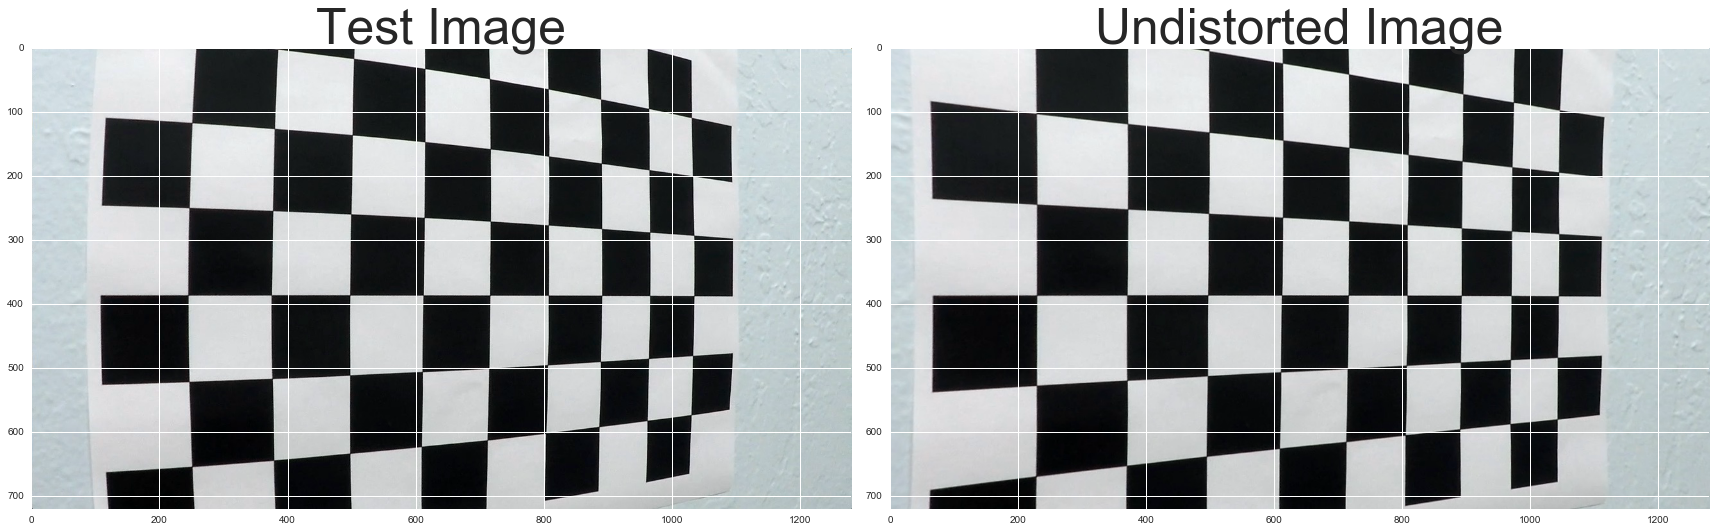

In [21]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# # Make a list of calibration images
# images = glob.glob('../camera_cal/calibration*.jpg')

# for fname in images:
#     img = cv2.imread(fname)
#     img = undistort(img)
    
    
test_chessboard_image = cv2.imread('../camera_cal/calibration5.jpg')

undistorted_image = undistort(test_chessboard_image)

plt.imsave('../output_images/Undistorted_image.jpeg',undistorted_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_chessboard_image)
ax1.set_title('Test Image', fontsize=50)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=50)

### Undistort our test image so it can be used later

In [32]:
#test_image = cv2.imread('../test_images/straight_lines1.jpg')
test_image = cv2.imread('../test_images/test6.jpg')

test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)


img_size = test_image.shape 

undistorted_test_image = undistort(test_image)



## Creating Thresholded Binary Images

### Threshold Our test image and compare with unthresholded
### For determing yellow colored lines applying x and y derivatives on the S channel in HLS colorspace followed by only keeping certain values in the H and S channel, provides good results. Because Yellow color lies within a certain range of S channel. The thresholds nd ranges were determined through experimentation

### For white lines x and y derivates were taken on L channel followed by filtering on certain values of L channel. This works because white lines tend to have high L values. The thresholds and ranges were determined through experimentation

In [29]:
def thresholded_image(img,  s_thresh=(170, 255), sx_thresh=(20, 100)):
    #print s_thresh
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsl[:,:,0]
    l_channel = hsl[:,:,1]
    s_channel = hsl[:,:,2]
    
    
    #######################################Determining Yellow Lines#######################################
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1)
        #abs_sobel = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobel = np.sqrt((sobelx**2) + (sobely**2))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
    yellow = np.zeros_like(s_channel)
    yellow[(h_channel >= 15) & (h_channel <= 30) & (s_channel >= 10) & (s_channel <= 255)] = 1 #10 and 255
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1]) & (yellow == 1)] = 1
    ######################################################################################################
    
    
    #######################################Determining White Lines########################################
    sobelx2 = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely2 = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1)
    #abs_sobel2 = np.absolute(sobelx2)
    abs_sobel2 = np.sqrt((sobelx2**2) + (sobely2**2))

    scaled_sobel2 = np.uint8(255*abs_sobel2/np.max(abs_sobel2))
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(scaled_sobel2 >= s_thresh[0]) & (scaled_sobel2 <= s_thresh[1]) & (l_channel >= 170)] = 1
    ######################################################################################################
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

### Here is the application on a sample image. We can see that even on a shadow part of the road, the line is correctly identified. The output image is also saved to output_images folder

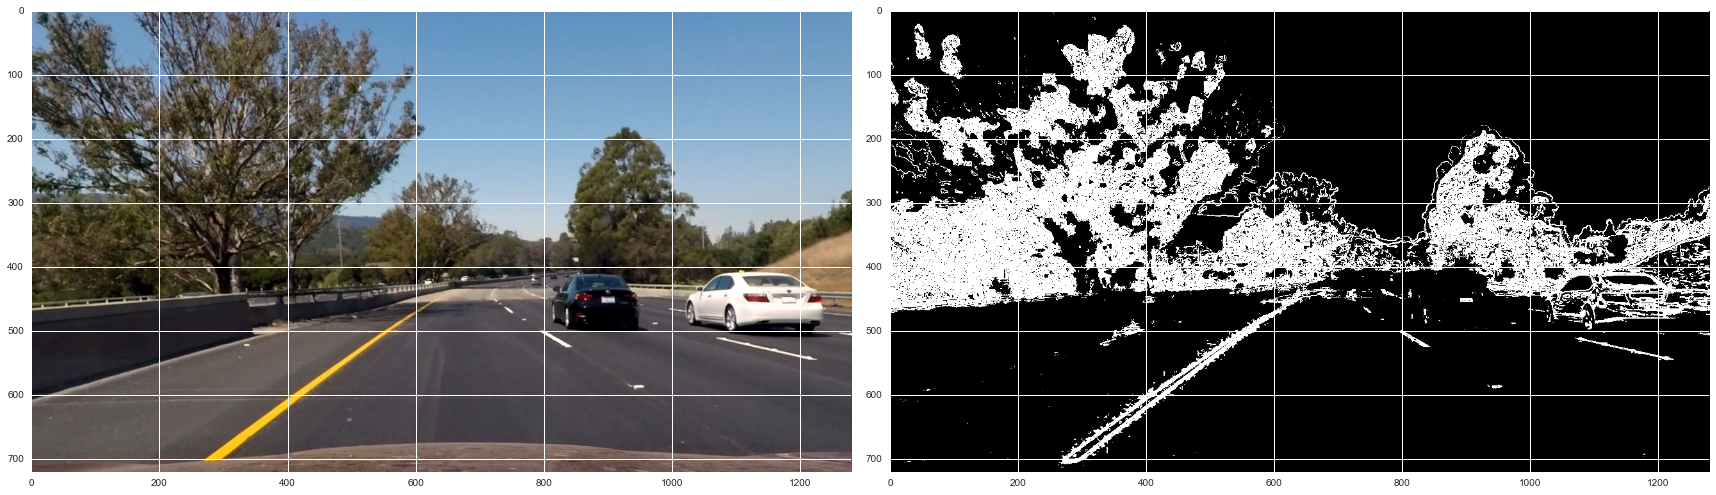

In [50]:
undistorted_test_image = undistort(test_image)

thresholded_undistorted_test_image = thresholded_image(undistorted_test_image, s_thresh=(10,255),  sx_thresh=(5,255))   
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

f.tight_layout()
ax1.imshow((undistorted_test_image))
ax2.imshow(thresholded_undistorted_test_image, cmap='gray')

plt.imsave('../output_images/thresholded_undistorted_image.jpeg',1-thresholded_undistorted_test_image)


### Warping the Image
#### In order to transform the image to bird eye's view correct I had to play with different values. Here I used an image with straight lines to make sure my transform values were correct.

#### I also used region of interest function from P1 to remove extra information from the images. The areas of interest are marked by the array cut and these points are different than src and dst arrays used for image transformation. This region of interest function is used later in the pipeline

In [ ]:
#test_image = cv2.imread('../test_images/test1.jpg')
#test_image = cv2.imread('../test_images/straight_lines1.jpg')
#test_image = cv2.imread('../images_from_videos/frame2.jpeg')

#test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)

In [8]:
img_size = (1280, 720)#img.shape[::-1][-2:]
 
top_right_src = [702, 460]
top_left_src = [580, 460]
bottom_right_src = [1050, 705]
bottom_left_src = [250, 705]
# src coordinates
src = np.float32([
    top_left_src,  # bottom right
    bottom_left_src, # bottom left
    bottom_right_src,
    top_right_src    # top left
])

top_right_dest = [900, 100]
top_left_dest = [450, 100]
bottom_right_dest = [900, 705]
bottom_left_dest = [450, 705]

dst = np.float32([
     # top right
     # bottom right
    top_left_dest,
    bottom_left_dest, # bottom left
    bottom_right_dest,
    top_right_dest,# top left
])

top_right_src2 = [735, 460]
top_left_src2 = [548, 460]
bottom_right_src2 = [1280, 705]
bottom_left_src2 = [0, 705]

cut = np.int32(\
    [top_left_src2,  # bottom right
    bottom_left_src2, # bottom left
    bottom_right_src2,
    top_right_src2] )

def warp_image(img, src, dst,img_size ):
    
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR) 

def draw_lines(img, array):
    img = np.copy(img)
    for idx in range(4):
        cv2.line(img, tuple(array[idx]), tuple(array[idx-1]), (255,0,0), 5)
    
    return img

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #print mask
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


### The first Image is used to calibrate the src and dst arrays for correct transformation.
### The straight lines should match with vertical line of the bounding box. Once they do our calibration is complete

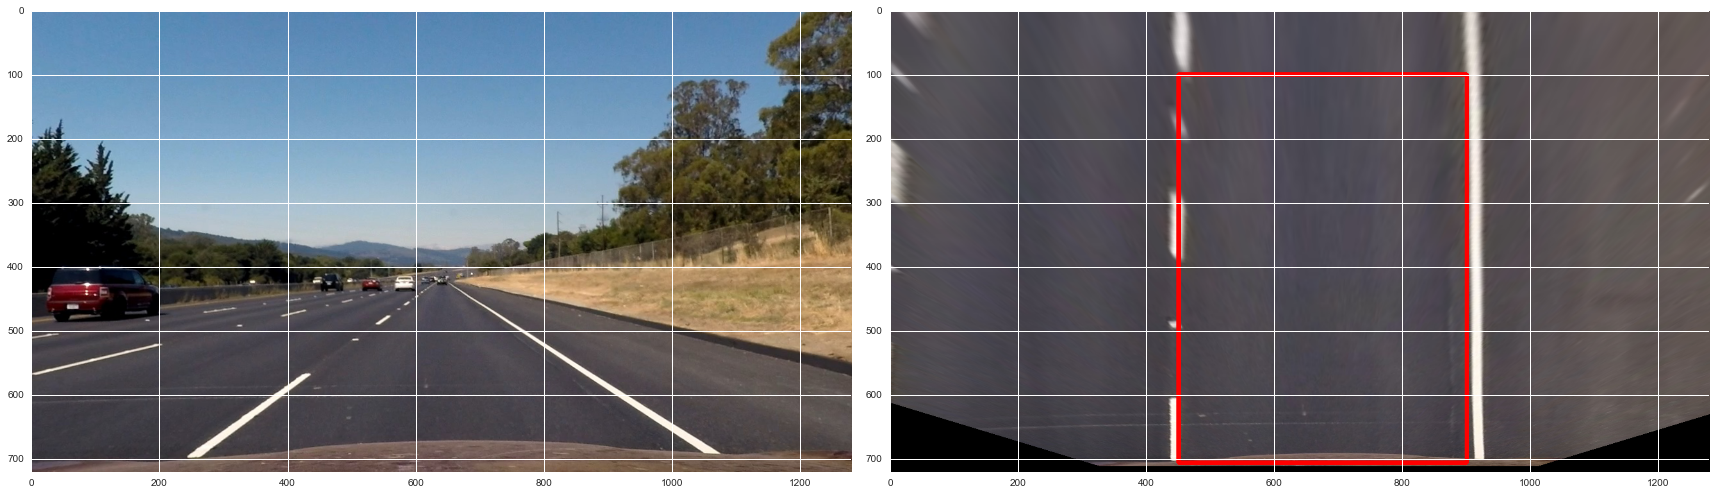

In [49]:
imgg = cv2.imread('../test_images/straight_lines2.jpg')
imgg = cv2.cvtColor(imgg,cv2.COLOR_BGR2RGB)

img_size = imgg.shape[::-1][-2:]

undistorted_imgg = undistort(imgg)
transformed_undistorted_imgg =  warp_image(undistorted_imgg,src, dst, img_size )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow((undistorted_imgg))
ax2.imshow(draw_lines(transformed_undistorted_imgg,dst))

plt.imsave('../output_images/transformed_undistorted_image_for_calibration.jpeg',transformed_undistorted_imgg)


### Now we apply the transformation to our test image we used in thresholding. The result below shows that transformation is working properly. We also used region of interest to cut out information that we don't need.

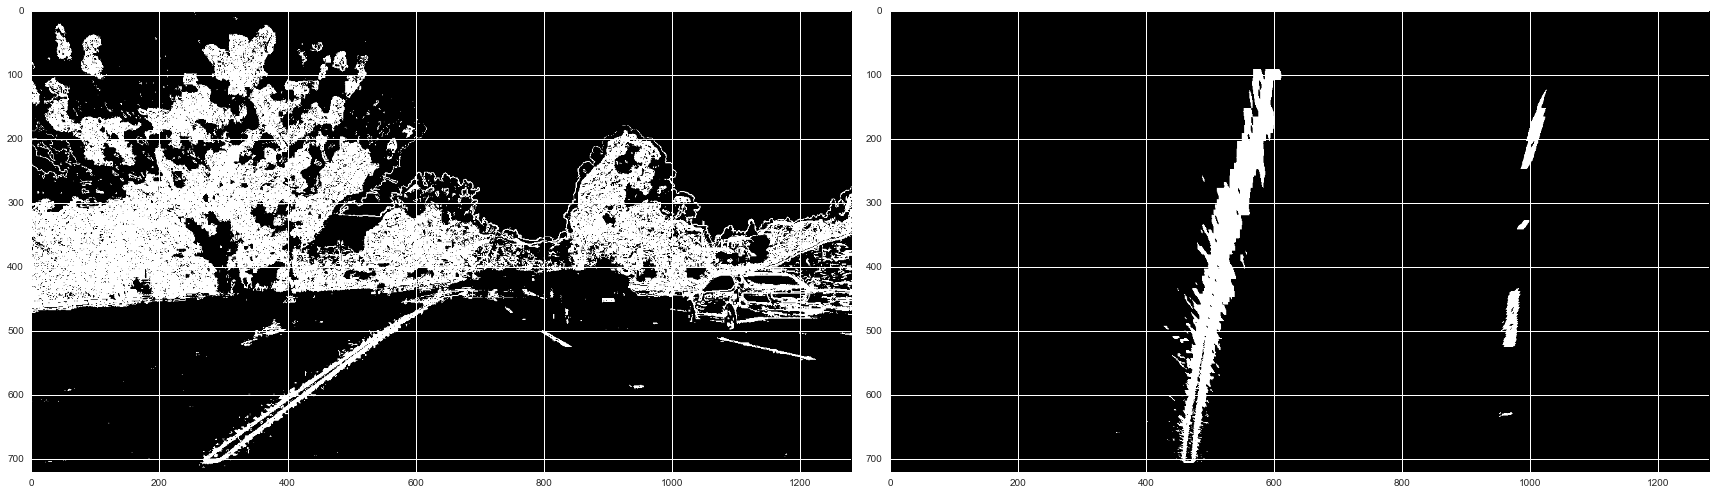

In [85]:
img_size = thresholded_undistorted_test_image.shape[::-1][-2:]

transformed_thresholded_undistorted_test_image =  \
               warp_image ( \
                region_of_interest (thresholded_undistorted_test_image, [cut.astype(int)]),\
                                                                                        src, dst, img_size )
    

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow((1- thresholded_undistorted_test_image))
ax2.imshow((1 - transformed_thresholded_undistorted_test_image))

plt.imsave('../output_images/transformed_undistorted_image.jpeg',1-transformed_thresholded_undistorted_test_image)



### Below is the function to determine the lane pixel on a image. This works by first determining histograms of points on the y-axis to determine the highest collection of points. We than find the peaks of the left and right halves and these are our starting points to start our search for lanes. For both sides we use 9 sliding windows. The height of the window is 1/9 of the image height. Each of these windows searches within an area and if it finds a minimum number of points (50) it makes that the center of the next window and it marks all the points within that window as potential points on the road. Once this process is done for all 9 sliding windows the marked points make up the lane.

### After identifying these points a 2nd order polynomial is fit through them and this makes up our lane on that side of the road.

In [89]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_estimates_of_lanes(binary_warped):
#try:
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    #for images were lanes aren't detected
    try:
        ((lefty[0] == 0) or (leftx[0] == 0) or (righty[0] == 0) or (rightx[0] == 0))
        
    except:
        return 0,0,0,0,0,out_img
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    ploty = np.linspace(binary_warped.shape[0]*.25, binary_warped.shape[0]-1, num=binary_warped.shape[0]*.25 )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]  #for plotting on graph
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] #for plotting on graph
    
    
    ym_per_pix = 30/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


    # needed for plotting later
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return left_fit, right_fit, left_fit_cr, right_fit_cr, leftx, rightx, ploty, out_img




### Shown below is application of the above function. The resulting image shows lanes identified with lanes marked with a polynomial.

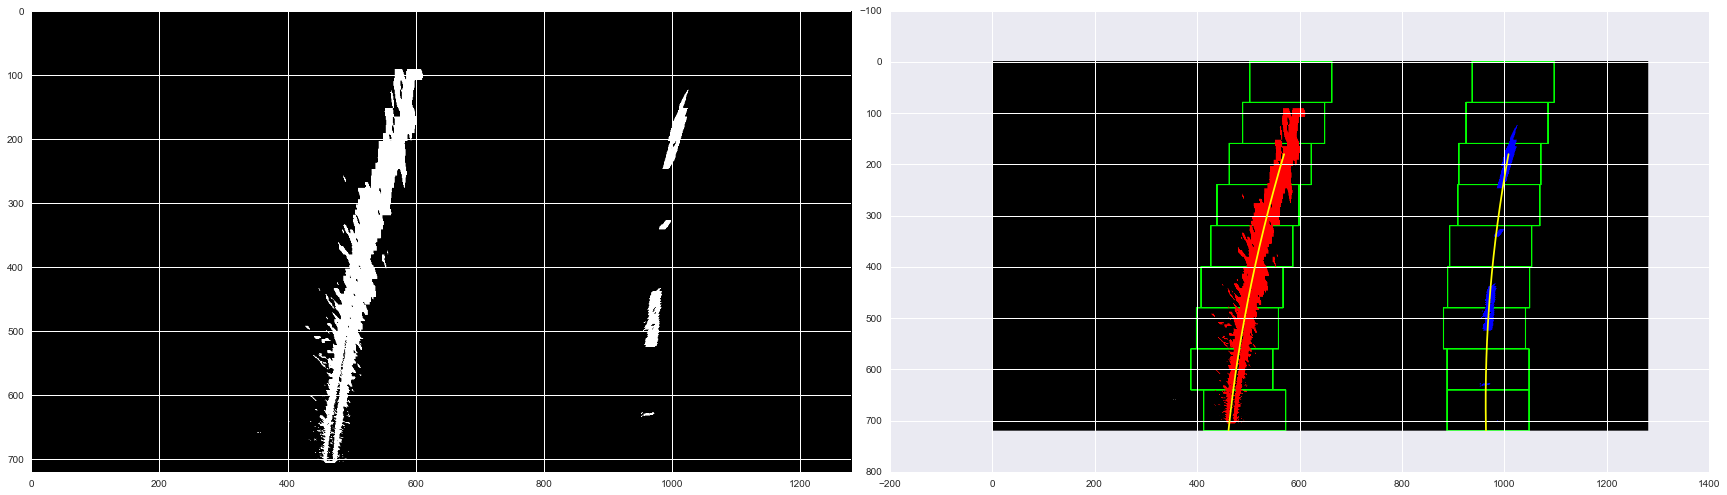

In [62]:
left_fit, right_fit, left_fit_cr,right_fit_cr, leftx, rightx, ploty, out_img, =\
                                                            get_estimates_of_lanes(transformed_thresholded_undistorted_test_image)
    
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]  #for plotting on graph
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]  #for plotting on graph
    
    
f , (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(1- transformed_thresholded_undistorted_test_image)
ax2.imshow(out_img )
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
#ax8.imshow(result)

plt.imsave('../output_images/lanes_identifies_with_sliding_windows.jpeg',out_img)



### We take the two polynomials (one for each lane) fit on adjusted pixels per meters and use them to calculate curvature by taking an average of both sides. We than convert these pixels to meters

### For position relative to center we take an average of first 5 pixels from the bottom that are identified as lane positions for both left and right. We then take an average of these two and compare them with the center of the image. The center is 675, this was calculated using the destination x-axis coordaintes of the bird eye's transformation (450 and 900)/2 = 675. 
### This center is calculated in the code below the function.

In [67]:
def get_curvature_in_meters(left_fit_cr, right_fit_cr, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/700.0 # meters per pixel in x dimension

    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad



### We multiply the final curvature with 2.5 to correct for any errors introduced from conversion between pixel and meters.

In [69]:
center_offset = ( 675 - (np.mean(leftx[:5]) + np.mean(rightx[:5]))/2.0) * (3.7/700)

left_curverad, right_curverad = get_curvature_in_meters(left_fit_cr, right_fit_cr, ploty)
total_curvature = (left_curverad + right_curverad)/2.0 * 2.5

print total_curvature, center_offset

2212.00287585 -0.200328571429


## Now that we have our curvature, and center offset along with identified lanes, its time to project them back to the original image. The following function takes in reverse transformation matrix along with polynomials for both lanes and projects those on the original undistorted image.

In [78]:


def draw_lines_on_road(binary_warped, undistorted_image, Minv, left_fit,right_fit, ploty):
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]  #for plotting on graph
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] #for plotting on graph

    
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size = binary_warped.shape
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_size[1], img_size[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result


### Here we also add the curvature and offset on the image

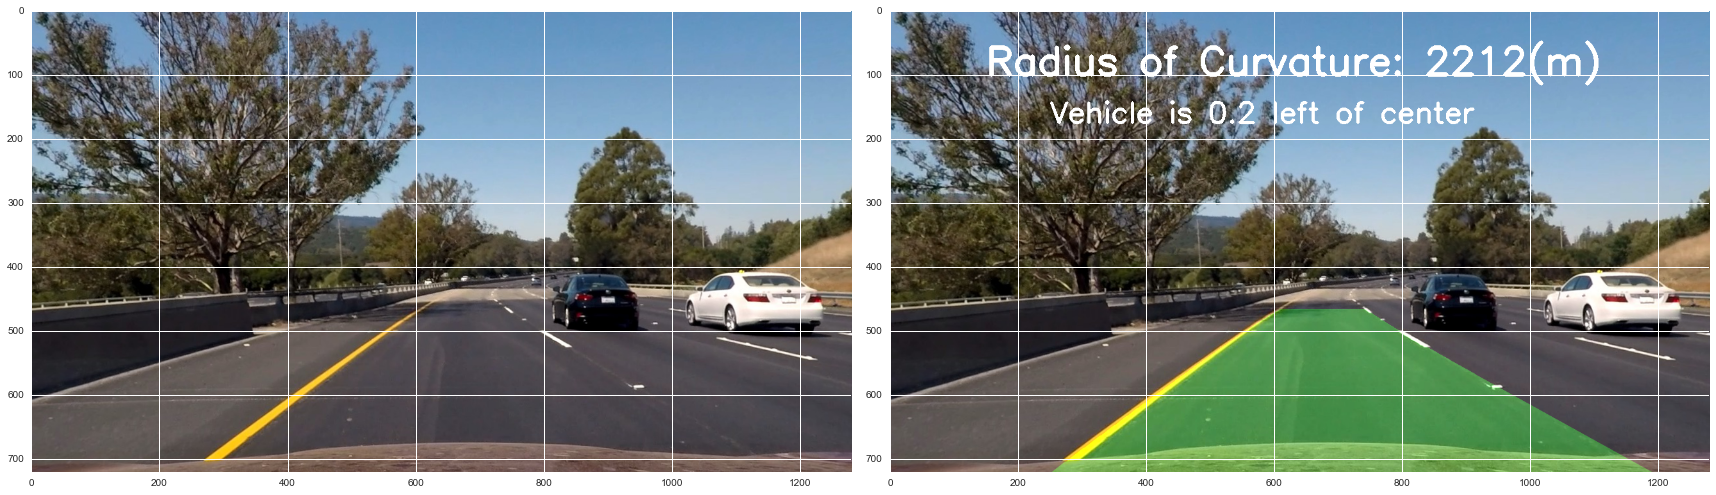

In [84]:
Minv = cv2.getPerspectiveTransform(dst, src)

result = draw_lines_on_road(transformed_thresholded_undistorted_test_image, undistorted_test_image, Minv, left_fit, right_fit, ploty)

curvat = str(int( total_curvature) )

offset = (np.round(center_offset,2))
cv2.putText(result,"Radius of Curvature: "+curvat+ '(m)', (150,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness =6)

if offset < 0:
    cv2.putText(result,"Vehicle is "+str(np.abs(offset))+ ' left of center', (250,175), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness =4)
if offset > 0:
    cv2.putText(result,"Vehicle is "+str(np.abs(offset))+ ' right of center', (250,175), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness =4)


f , (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_test_image)
ax2.imshow(result)

plt.imsave('../output_images/final_image_with_curvature_offset_project_lanes.jpeg',result)


### The following the class is used to capture results from previous identifications and produce a smooth result.

In [10]:
class Line():
    def __init__(self):

        # x values of the last n fits of the line
        self.history_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients for the history of recent fits
        self.history_fit = []  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #history radius of  curavture
        self.history_radius_of_curvature = []
        #radius of curvature of the line in some units
        self.best_radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = [] 
 


In [88]:
1/1.25

0.8

### The following is the actual pipeline which processes all the above mentioned steps plus keeping track of previous lane identifications to produce images that are not jittery.

### The lane identification for both sides is only captured if the lane is within a certain range of the average of the past curvatures of that lane. So if the curvature of the left lane is less than 3 times and greater than 1/3 of the average of the last 10 curvatures of the left lane, then it will be captured. The displayed lane boundary is average of last 10 such identified boundaries.

### For the combined curvature of the road, it is only captured if the ratio between left and right curvature is less than 1.25 and greater than  (1/1.25) = 0.8. The displayed curvature is an average of last 25 such curvatures.

### For offset from the center, it is only captured if the ratio between left and right curvature is less than 1.25 and greater than  (1/1.25) = 0.8. The displayed offset is an average of last 20 offsets.

In [91]:
LEFT = Line()
RIGHT = Line()
CENTER = Line()
def pipeline(image, display_all_steps = False, display_last_step = False ):

    img_size = image.shape[::-1][-2:]
    
    undistorted_image = undistort(image)

    thresholded_undistorted_image = thresholded_image(undistorted_image, s_thresh=(10,255),  sx_thresh=(5,255))
 
    thresholded_undistorted_image = region_of_interest(thresholded_undistorted_image,[cut.astype(int)] )
 
    transformed_thresholded_undistorted_image =  (warp_image(thresholded_undistorted_image,src, dst, img_size ))
    
    Minv = cv2.getPerspectiveTransform(dst, src)
        
    left_fit, right_fit, left_fit_cr,right_fit_cr, leftx, rightx, ploty, out_img, =\
                                                            get_estimates_of_lanes(transformed_thresholded_undistorted_image);
    #Check for images that return nothing
    if type(left_fit_cr) is not np.ndarray and  type(right_fit_cr) is not np.ndarray:
        plt.imshow(image)
        cv2.imwrite('../bad_images.jpeg', cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        return image
    
####################################################Using Line Class for Smoothing###############################################################################
#################################################################################################################################################################
    

    window = 10   #6
    window2 = 25   
    curvat_diff = 3  #2
    combined_curvat_diff = 1.25
    left_curverad, right_curverad = get_curvature_in_meters(left_fit_cr, right_fit_cr, ploty)

    if LEFT.bestx == None:
        LEFT.bestx = left_fit_cr
        LEFT.best_fit = left_fit
        RIGHT.bestx = right_fit_cr
        RIGHT.best_fit = right_fit
        
        LEFT.best_radius_of_curvature = left_curverad
        RIGHT.best_radius_of_curvature = right_curverad
           
    if (len(LEFT.history_fit) == 0 ) or ((LEFT.best_radius_of_curvature/left_curverad < curvat_diff ) and (LEFT.best_radius_of_curvature/left_curverad > (1/curvat_diff))):
        LEFT.history_xfitted.append(left_fit_cr)
        LEFT.history_fit.append(left_fit)
  
    if (len(RIGHT.history_fit) == 0 ) or ((RIGHT.best_radius_of_curvature/right_curverad < curvat_diff ) and (RIGHT.best_radius_of_curvature/right_curverad > (1/curvat_diff))):
        RIGHT.history_xfitted.append(right_fit_cr)
        RIGHT.history_fit.append(right_fit)
    
    if len(RIGHT.history_xfitted) > 1:
        RIGHT.bestx = np.mean(np.array(RIGHT.history_xfitted[-window:]), axis = 0)
        RIGHT.best_fit = np.mean(np.array(RIGHT.history_fit[-window:]), axis = 0)
        RIGHT.best_radius_of_curvature = np.mean(np.array(RIGHT.history_radius_of_curvature[-window2:]), axis = 0)
    if len(LEFT.history_xfitted) > 1:
        LEFT.bestx = np.mean(np.array(LEFT.history_xfitted[-window:]), axis = 0) 
        LEFT.best_fit = np.mean(np.array(LEFT.history_fit[-window:]), axis = 0)
        LEFT.best_radius_of_curvature = np.mean(np.array(LEFT.history_radius_of_curvature[-window2:]), axis = 0)
    
        
    if (left_curverad/right_curverad < combined_curvat_diff and left_curverad/right_curverad > (1/combined_curvat_diff)) or (len(CENTER.line_base_pos) == 0) :
        LEFT.history_radius_of_curvature.append([left_curverad])
        RIGHT.history_radius_of_curvature.append([right_curverad])
        
        center_offset_temp = ( 675 - (np.mean(leftx[:5]) + np.mean(rightx[:5]))/2.0) * (3.7/700)
        CENTER.line_base_pos.append([center_offset_temp])
 
#
#################################################################################################################################################################
#################################################################################################################################################################


    center_offset = np.mean(np.array(CENTER.line_base_pos[-20:]), axis = 0)[0]
    curvature_offset = (LEFT.best_radius_of_curvature, 'm', RIGHT.best_radius_of_curvature, 'm', center_offset)
        
    result = draw_lines_on_road(transformed_thresholded_undistorted_image, undistorted_image, Minv, LEFT.best_fit,RIGHT.best_fit, ploty)
   
        
    curvat = str(int( (curvature_offset[0] + curvature_offset[2])/2 * 2.5) )
    #print curvature_offset[0], curvature_offset[1]
    
    offset = (np.round(curvature_offset[-1],2))
    cv2.putText(result,"Radius of Curvature: "+curvat+ '(m)', (150,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness =6)
    #cv2.putText(result,str(int(curvature_offset[0])) +' '+str(int(curvature_offset[2])), (500,300), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), thickness =6)

    if offset < 0:
        cv2.putText(result,"Vehicle is "+str(np.abs(offset))+ ' left of center', (250,175), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness =4)
    if offset > 0:
        cv2.putText(result,"Vehicle is "+str(np.abs(offset))+ ' right of center', (250,175), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness =4)

###################################################Display Results for Diagnostics###############################################################################        
#################################################################################################################################################################
        
    left_fitx = LEFT.best_fit[0]*ploty**2 + LEFT.best_fit[1]*ploty + LEFT.best_fit[2]  #for plotting on graph
    right_fitx = RIGHT.best_fit[0]*ploty**2 + RIGHT.best_fit[1]*ploty + RIGHT.best_fit[2]  #for plotting on graph
    
    if display_all_steps == True:
        print curvature_offset
        f, ((ax1, ax2), (ax3, ax4),(ax5, ax6),(ax7, ax8) ) = plt.subplots(4, 2, figsize=(12, 12))
        f.tight_layout()
        
        ax1.imshow(undistorted_image )
        ax2.imshow(1-thresholded_undistorted_image )

        ax3.imshow(draw_lines(warp_image(undistorted_image,src, dst, img_size ), dst) )
        ax4.imshow(1- transformed_thresholded_undistorted_image)
        
        histogram = np.sum(transformed_thresholded_undistorted_image[transformed_thresholded_undistorted_image.shape[0]/2:,:], axis=0)
    
        ax5.plot(histogram )

        ax7.imshow(out_img )
        ax7.plot(left_fitx, ploty, color='yellow')
        ax7.plot(right_fitx, ploty, color='yellow')
        ax8.imshow(result)
    
    elif display_last_step == True:
        print curvature_offset
        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 12))
        f.tight_layout()
        
        ax1.imshow(out_img )
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')
        ax2.imshow(result )
        
    else:
        return result
 


In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Applying the pipeline on the video

In [15]:
LEFT = Line()
RIGHT = Line()
CENTER = Line()

test_output = 'final.mp4'
clip1 = VideoFileClip("../challenge_video.mp4")

white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video final.mp4
[MoviePy] Writing video final.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:42<00:00,  4.81it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: final.mp4 

Wall time: 1min 43s


## When Passing an image to the whole pipe and enabling diagnotics we can see the results from each stage

(909.00453512269962, 'm', 860.59776555988458, 'm', -0.20032857142857133)


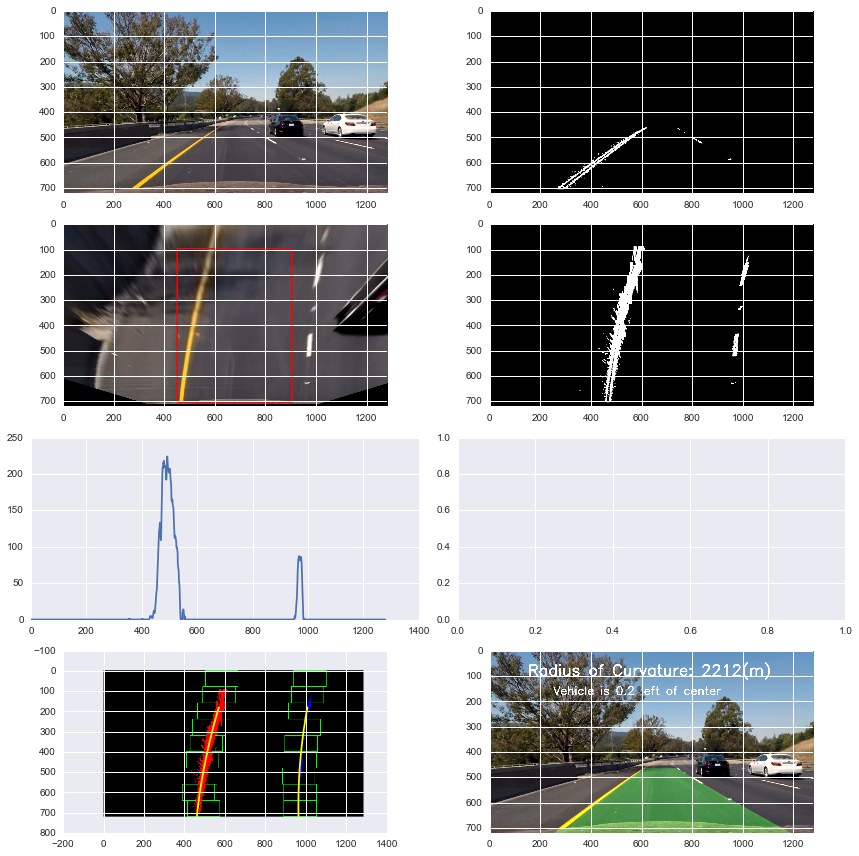

In [82]:

LEFT = Line()
RIGHT = Line()
CENTER = Line()
imgg = cv2.imread('../test_images/test6.jpg')
#imgg = cv2.imread('../test_images/straight_lines2.jpg')

pipeline(cv2.cvtColor(imgg,cv2.COLOR_BGR2RGB), display_all_steps=True);


(14660.177080105088, 'm', 14595.309799195773, 'm', 0.0058142857142858351)


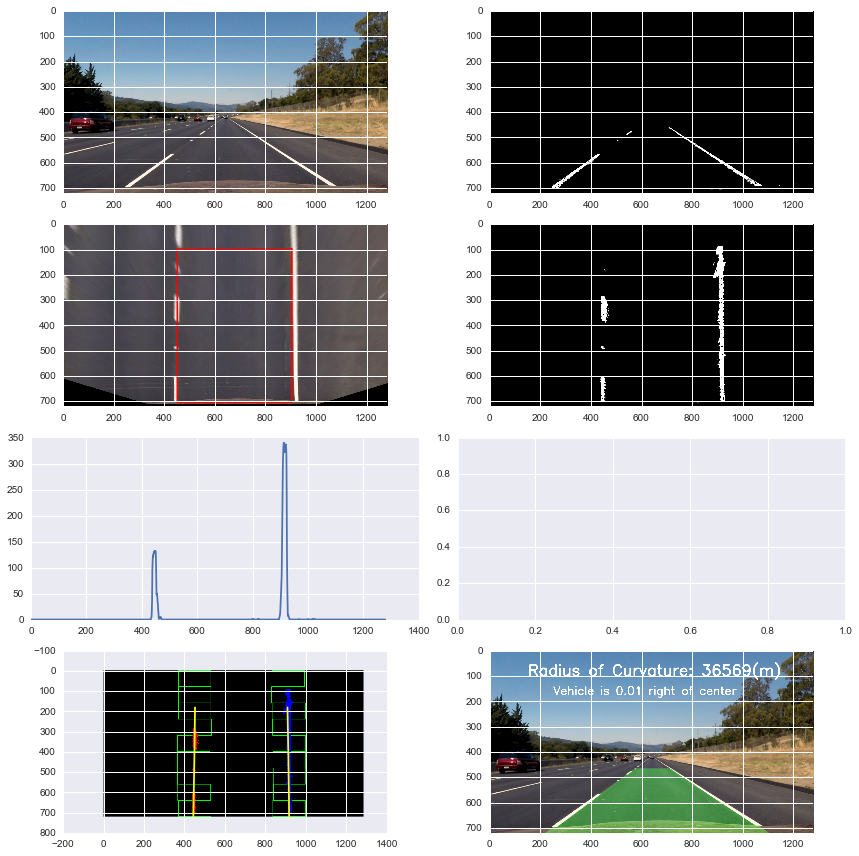

In [92]:
LEFT = Line()
RIGHT = Line()
CENTER = Line()
#imgg = cv2.imread('../test_images/test6.jpg')
imgg = cv2.imread('../test_images/straight_lines2.jpg')

pipeline(cv2.cvtColor(imgg,cv2.COLOR_BGR2RGB), display_all_steps=True);

## Discussion

### Some of the problems faced included accurately detecting the white lines in a bright photo. After the car comes out of the bridge the camera is still adjusted to darkness for a while so the first few seconds of images are really bright. For this reason I also had to do thresholding on L channel instead of simply filtering out certain values.

### For improvements, instead of searching blindly each time for the lanes, using information from the previous frames to search for new lanes will make the detection even better. 

### Pipeline Failure: A scenario in which most of the car is travelling under the bridge might cause the pipeline to breakdown. This is because most of the pipeline was trained on non-shadow images. If the lanes aren't detected for a long time the average of the previous detected lanes will fail to generate good results.